# Initial setups

In [1]:
using JuMP
using Gurobi
env = Gurobi.Env()

using Plots

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


# Simple 3-bus case

## Results report functions

In [2]:
function plot_results_frame(P01M, P02M, b01, b02)
    coef = 2
    nb = 20
    scale(i) = coef * i / nb
    i = range(0, nb)
    vec_range = scale.(i)
    p = plot([0, coef * P01M], [P02M, P02M], lc = :red, legend = false)
    plot!([P01M, P01M], [0, coef * P02M], lc = :red)
    plot!([0, P01M * coef], min((1+b02/b01) * P01M, (1+b01/b02) * P02M) .- [0, coef * P01M], lc = :blue)
    xlabel!("P1")
    ylabel!("P2")
    xlims!(0, P01M*coef)
    ylims!(0, P02M*coef)
end

function plot_results(p, P1, P2, ls1, ls2, sw, show_orig::Bool= false, show_target::Bool= false)
    if show_orig
        ls = ls1 + ls2
        scatter!(p, [P1],[P2], msw=0, mc = sw==0 ? :red : :blue, markershape = ls==0 ? :xcross : :circle,
            markersize = ls==0 ? 3 : (7 * ls))
    end
    if show_target
        scatter!(p, [P1 - ls1], [P2 - ls2], mc= sw==0 ? :red : :green, markershape = :xcross, markersize = 1)
    end
end

function single_result(model_builder, P01M, P02M, b01, b02, P1, P2, verbose = false)
    model = model_builder(P01M, P02M, b01, b02, P1, P2)
    optimize!(model)
    if verbose
        print(model)
        print(solution_summary(model))
        print("\nls1: $(value(model[:ls1])), ls2: $(value(model[:ls2])), sw:$(value(model[:sw]))")
    end
    p = plot_results_frame(P01M, P02M,b01, b02)
    plot_results(p, P1, P2, value(model[:ls1]), value(model[:ls2]), value(model[:sw]), true, true)
end

function build_grid_results(model_builder, P01M, P02M, b01, b02, nb, coef)
    result = Array{NTuple{5, Float64}, 2}(undef, nb+1, nb+1)
    for i in 1 : nb + 1
        for j in 1 : nb + 1
            P1 = coef * P01M * (i-1) / nb
            P2 = coef * P02M * (j-1) / nb
            m = model_builder(P01M, P02M, b01, b02, P1, P2)
            optimize!(m)
            result[i,j] = (P1, P2, value(m[:ls1]), value(m[:ls2]),  value(m[:sw]))
        end
    end
    result
end

function plot_grid_results(P01M, P02M, b01, b02, result)
    p = plot_results_frame(P01M, P02M, b01, b02)
    for (i, (P1, P2, ls1, ls2, sw)) in enumerate(result)
        plot_results(p, P1, P2, ls1, ls2, sw, true, false)
    end
    display(p)
end

plot_grid_results (generic function with 1 method)

## Model without parameters

In [3]:
function build_model(P01M, P02M, b01, b02, P1, P2)
    bM = 1e3

    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    @variable(model, 0 ≤ ls1 ≤ P1)
    @variable(model, 0 ≤ ls2 ≤ P2)
    @variable(model, sw, Bin)

    constr_sw_open(p, ls, sw, p_max) =
        @constraint(model, p - ls - sw * bM ≤p_max)
    
    constr_sw_close(p1, p2, ls1, ls2, b1, b2, sw, p_max) =
        @constraint(model, b1 / (b1 + b2) * (p1 + p2 - ls1 - ls2) - (1 - sw) * bM ≤ p_max)
    
    constr_sw_open(P1, ls1, sw, P01M)
    constr_sw_open(P2, ls2, sw, P02M)
    constr_sw_close(P1, P2, ls1, ls2, b01, b02, sw, P01M)
    constr_sw_close(P1, P2, ls1, ls2, b02, b01, sw, P02M)
    @objective(model, Min, ls1 + ls2 - sw / 1000)

    return model
end


build_model (generic function with 1 method)

In [4]:
b01, b02 = 1.25, 1
P1, P2 = 1.5, 1.4
P01M, P02M = 1.5, 1
bM = 1e3
model = build_model(P01M, P02M, b01, b02, P1, P2)
optimize!(model)
print(solution_summary(model))
print("\nls1: $(value(model[:ls1])), ls2: $(value(model[:ls2])), sw:$(value(model[:sw]))")
latex_formulation(model)

* Solver : Gurobi

* Status
  Result count       : 2
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 4.00000e-01
  Objective bound    : 4.00000e-01
  Relative gap       : 0.00000e+00
  Dual objective value : 4.00000e-01

* Work counters
  Solve time (sec)   : 7.09581e-03
  Barrier iterations : 0
  Node count         : 0

ls1: 0.0, ls2: 0.3999999999999999, sw:0.0

$$ \begin{aligned}
\min\quad & ls1 + ls2 - 0.001 sw\\
\text{Subject to} \quad & -ls1 - 1000 sw \leq 0\\
 & -ls2 - 1000 sw \leq -0.3999999999999999\\
 & -0.5555555555555556 ls1 - 0.5555555555555556 ls2 + 1000 sw \leq 999.8888888888889\\
 & -0.4444444444444444 ls1 - 0.4444444444444444 ls2 + 1000 sw \leq 999.7111111111111\\
 & ls1 \geq 0\\
 & ls2 \geq 0\\
 & ls1 \leq 1.5\\
 & ls2 \leq 1.4\\
 & sw \in \{0, 1\}\\
\end{aligned} $$

## Model with parameters
The problem is the parameters is seen as a variable from the Gurobi side, and therefore, the problems becomes unnecessarily quadratic.

But the latex output is more readable !

In [5]:
function build_model_parameters(P1M, P2M, b01, b02, P1, P2)
    bM = 1e3

    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)
    @variable(model, M in Parameter(bM))
    @variable(model, p1 in Parameter(P1))
    @variable(model, p2 in Parameter(P2))
    @variable(model, p1_max in Parameter(P1M))
    @variable(model, p2_max in Parameter(P2M))
    @variable(model, α in Parameter(1e-3))
    @variable(model, 0 ≤ ls1)
    @variable(model, 0 ≤ ls2)
    @variable(model, sw, Bin)

    constr_sw_open(p, ls, sw, p_max) =
        @constraint(model, p - ls - sw * M ≤ p_max)
    
    constr_sw_close(p1, p2, ls1, ls2, b1, b2, sw, p_max) =
        @constraint(model, b1 / (b1 + b2) * (p1 + p2 - ls1 - ls2) - (1 - sw) * M ≤ p_max)

    @constraint(model, ls1 ≤ p1)
    @constraint(model, ls2 ≤ p2)
    
        
    constr_sw_open(p1, ls1, sw, p1_max)
    constr_sw_open(p2, ls2, sw, p2_max)
    constr_sw_close(p1, p2, ls1, ls2, b01, b02, sw, p1_max)
    constr_sw_close(p1, p2, ls1, ls2, b02, b01, sw, p2_max)
    @objective(model, Min, ls1 + ls2 - sw * α)

    return model
end


build_model_parameters (generic function with 1 method)

In [6]:
model = build_model_parameters(P01M, P02M, b01, b02, P1, P2)
optimize!(model)
print(solution_summary(model))
print("\nls1: $(value(model[:ls1])), ls2: $(value(model[:ls2])), sw:$(value(model[:sw]))")
latex_formulation(model)


* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 4.00000e-01
  Objective bound    : 4.00000e-01
  Relative gap       : 0.00000e+00
  Dual objective value : 4.00000e-01

* Work counters
  Solve time (sec)   : 1.63198e-03
  Barrier iterations : 0
  Node count         : 0

ls1: 0.0, ls2: 0.4, sw:0.0

$$ \begin{aligned}
\min\quad & -sw\times α + ls1 + ls2\\
\text{Subject to} \quad & -p1 + ls1 \leq 0\\
 & -p2 + ls2 \leq 0\\
 & -sw\times M + p1 - p1\_max - ls1 \leq 0\\
 & -sw\times M + p2 - p2\_max - ls2 \leq 0\\
 & sw\times M - M + 0.5555555555555556 p1 + 0.5555555555555556 p2 - p1\_max - 0.5555555555555556 ls1 - 0.5555555555555556 ls2 \leq 0\\
 & sw\times M - M + 0.4444444444444444 p1 + 0.4444444444444444 p2 - p2\_max - 0.4444444444444444 ls1 - 0.4444444444444444 ls2 \leq 0\\
 & ls1 \geq 0\\
 & ls2 \geq 0\\
 & sw \in \{0, 1\}\\
 & M \in \text{MathOptInterface.Parameter\{Float64\}(1000.0)}\\
 & p1 \in \text{MathOptInterface.Parameter\{Float64\}(1.5)}\\
 & p2 \in \text{MathOptInterface.Parameter\{Float64\}(1.4)}\\
 & p1\_max \in \text{MathOptInterface.Parameter\{Float64\}(1.5)}\\
 & p2\_max \in \text{MathOptInterface.Parameter\{Float64\}(1.0)}\\
 & α \in \text{MathOptInterface.Parameter\{Float64\}(0.001)}\\
\end{aligned} $$

## Results

### Single result

Min ls1 + ls2 - 0.001 sw
Subject to
 -ls1 - 1000 sw ≤ 0
 -ls2 - 1000 sw ≤ -0.3999999999999999
 -0.5555555555555556 ls1 - 0.5555555555555556 ls2 + 1000 sw ≤ 999.8888888888889
 -0.4444444444444444 ls1 - 0.4444444444444444 ls2 + 1000 sw ≤ 999.7111111111111
 ls1 ≥ 0
 ls2 ≥ 0
 ls1 ≤ 1.5
 ls2 ≤ 1.4
 sw binary
* Solver : Gurobi

* Status
  Result count       : 2
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 4.00000e-01
  Objective bound    : 4.00000e-01
  Relative gap       : 0.00000e+00
  Dual objective value : 4.00000e-01

* Work counters
  Solve time (sec)   : 2.02179e-04
  Barrier iterations : 0
  Node count         : 0

ls1: 0.0, ls2: 0.3999999999999999, sw:0.0

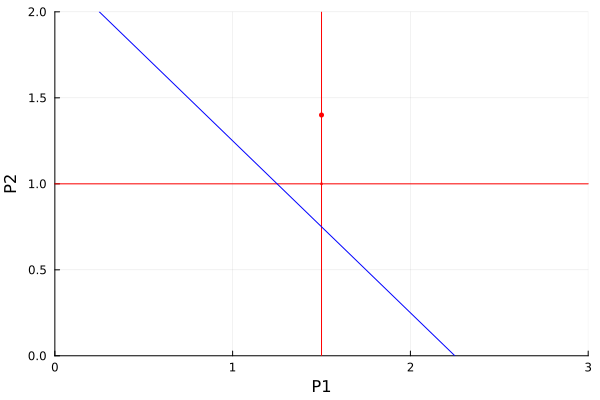

In [7]:
single_result(build_model, 1.5, 1, 1.25, 1, 1.5, 1.4, true)

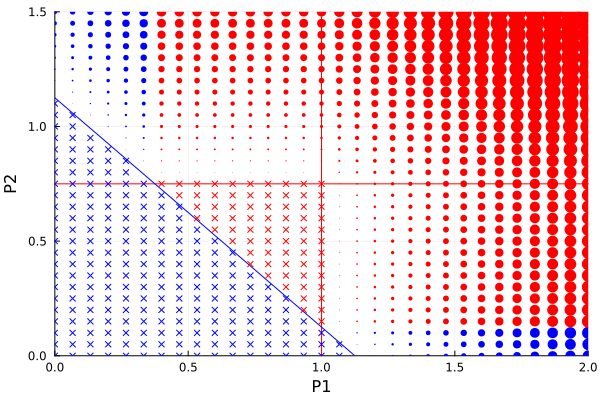

In [8]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
nb, coef = 30, 2

result = build_grid_results(build_model, P01M, P02M, b01, b02, nb, coef)
plot_grid_results(P01M, P02M, b01, b02, result)

## Bus splitting

In [9]:
function build_model_bus_splitting(P01M, P02M, b01, b02, P1, P2)
    bM = 1e3
    
    p_list = Dict(1 => P1, 2 => P2)

    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)
    
    bus_set = 1:2
    b = b01, b02
    P = P1, P2
    PM = P01M, P02M
    
    @variable(model, ls[i in bus_set] ≥ 0)
    @variable(model, sw, binary=true)
    @variable(model, swi[i in bus_set], binary=true)
    
    @constraint(model, [i = bus_set], ls[i] ≤ P[i] )
    @constraint(model, constr_sw_open_on_line_a[i in bus_set], 
                P[2] - ls[2] - (sw + swi[i]) * bM ≤ PM[i])
    
    @constraint(model, constr_sw_open_on_line_b[i in bus_set], 
                P[1] - ls[1] - (sw + 1 - swi[i]) * bM ≤ PM[i])
    
    @constraint(model, constr_sw_close[i in bus_set], 
                b[i] / (b[1] + b[2]) * (P[1] + P[2] - ls[1] - ls[2]) - (1 - sw) * bM ≤ PM[i])
    
    @constraint(model, const_connect1, sum(swi) - sw ≤ 1)
    @constraint(model, const_connect2, sum(swi) + sw ≥ 1)
    
    @objective(model, Min, sum(ls) - sw/1000)

    model[:ls1] = ls[1]
    model[:ls2] = ls[2]
    model[:sw] = sw

    return model
end


build_model_bus_splitting (generic function with 1 method)

Min ls[1] + ls[2] - 0.001 sw
Subject to
 const_connect2 : sw + swi[1] + swi[2] ≥ 1
 ls[1] ≤ 0.7
 ls[2] ≤ 0.8
 constr_sw_open_on_line_a[1] : -ls[2] - 1000 sw - 1000 swi[1] ≤ 0.19999999999999996
 constr_sw_open_on_line_a[2] : -ls[2] - 1000 sw - 1000 swi[2] ≤ -0.050000000000000044
 constr_sw_open_on_line_b[1] : -ls[1] - 1000 sw + 1000 swi[1] ≤ 1000.3
 constr_sw_open_on_line_b[2] : -ls[1] - 1000 sw + 1000 swi[2] ≤ 1000.05
 constr_sw_close[1] : -0.3333333333333333 ls[1] - 0.3333333333333333 ls[2] + 1000 sw ≤ 1000.5
 constr_sw_close[2] : -0.6666666666666666 ls[1] - 0.6666666666666666 ls[2] + 1000 sw ≤ 999.75
 const_connect1 : -sw + swi[1] + swi[2] ≤ 1
 ls[1] ≥ 0
 ls[2] ≥ 0
 sw binary
 swi[1] binary
 swi[2] binary
* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  

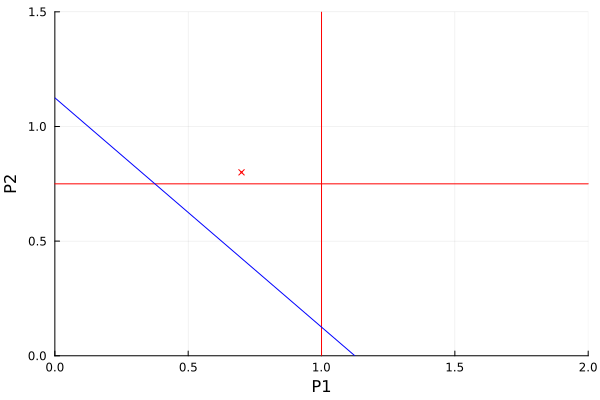

In [10]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
P1, P2 = .7, .8
single_result(build_model_bus_splitting,  P01M, P02M, b01, b02, P1, P2, true)

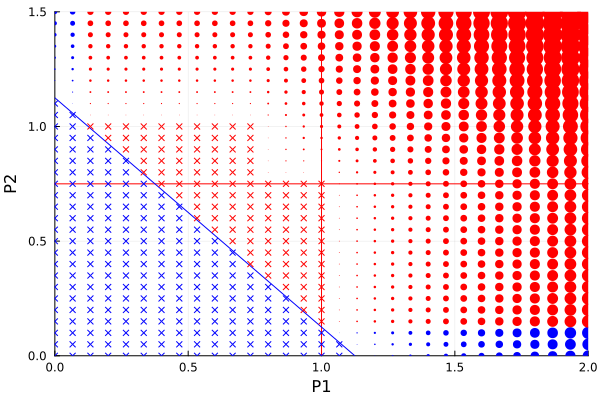

In [10]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
nb, coef = 30, 2
result = build_grid_results(build_model_bus_splitting, P01M, P02M, b01, b02, nb, coef)
plot_grid_results(P01M, P02M, b01, b02, result)

# Branch swityching only - general case

# model

## DC PF

In [11]:
struct Branch
    b::Float64
    p_max::Float64
    v_nom1::Float64
    v_nom2::Float64
    p::Float64
    Branch(b, p_max) = new(b, p_max, 0, 0, 0)
    Branch(b, p_max, v_nom1, v_nom2) = new(b, p_max, v_nom1, v_nom2, 0)
    Branch(b::Branch) = new(b.b, b.p_max, b.v_nom1, b.v_nom2, b.p)
    Branch(b::Branch, p_max) = new(b.b, p_max, b.v_nom1, b.v_nom2, b.p)
end

struct BranchId
    bus1
    bus2
end

function dc_pf(p_buses, branches, slack_id = nothing)
    # init_DC_model
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    slack_id = slack_id == nothing ? argmax(p_buses) : slack_id

    buses = (keys(p_buses))
    branch_ids = (keys(branches))

    @variable(model, θ[bus in buses])
    @constraint(model, slack, θ[slack_id] == 0)

    # dc_pf
    @variable(model, flows[br in branch_ids])
    #bus balance constraint
    @constraint(model, bus_balance_constraint[bus in buses; bus ≠ slack_id],
        p_buses[bus] + sum(flows[br] for br in branch_ids if bus == br.bus1)
                     - sum(flows[br] for br in branch_ids if bus == br.bus2) == 0)

    @constraint(model, flow_constraint[br in branch_ids],
        branches[br].b * (θ[br.bus2] - θ[br.bus1]) == flows[br])
    model
end

dc_pf (generic function with 2 methods)

In [13]:
branches = Dict([
            (BranchId("0", "1") => Branch(1, 1)),
            (BranchId("1", "2") => Branch(1, 1)),
            (BranchId("0", "2") => Branch(1, 1))])
p_buses = Dict([("0" => 0), ("1" => -2), ("2" => -1)])

model = dc_pf(p_buses, branches, "0")
optimize!(model)
# println(solution_summary(model))
for v in all_variables(model)
    println("$v = $(value(v))")
end
latex_formulation(model)


θ[1] = -1.6666666666666667
θ[0] = 0.0
θ[2] = -1.3333333333333335
flows[BranchId("0", "1")] = -1.6666666666666667
flows[BranchId("1", "2")] = 0.33333333333333337
flows[BranchId("0", "2")] = -1.3333333333333335


$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & θ_{0} = 0\\
 & -flows_{BranchId("0", "1")} + flows_{BranchId("1", "2")} = 2\\
 & -flows_{BranchId("1", "2")} - flows_{BranchId("0", "2")} = 1\\
 & θ_{1} - θ_{0} - flows_{BranchId("0", "1")} = 0\\
 & -θ_{1} + θ_{2} - flows_{BranchId("1", "2")} = 0\\
 & -θ_{0} + θ_{2} - flows_{BranchId("0", "2")} = 0\\
\end{aligned} $$

## DC OTS

In [20]:
function dc_ots(p_buses, branches, slack_id = nothing)
    # init_DC_model
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    slack_id = slack_id == nothing ? argmax(p_buses) : slack_id

    buses = (keys(p_buses))
    branch_ids = (keys(branches))
    bigM= 1e3

    @variable(model, θ[bus in buses])
    @constraint(model, slack, θ[slack_id] == 0)

    @variable(model, flows[br in branch_ids], lower_bound = -branches[br].p_max, upper_bound = branches[br].p_max)
    @variable(model, ls[bus in buses; bus ≠ slack_id], lower_bound = 0, upper_bound = max(0, - p_buses[bus]))
    @variable(model, sw[br in branch_ids], Bin)

    @constraint(model, close_le[br in branch_ids],
        flows[br] - branches[br].b * (θ[br.bus1] - θ[br.bus2]) - (1 - sw[br]) * bigM ≤ 0)
    @constraint(model, close_ge[br in branch_ids],
        flows[br] - branches[br].b * (θ[br.bus1] - θ[br.bus2]) + (1 - sw[br]) * bigM ≥ 0)
    @constraint(model, open_le[br in branch_ids], flows[br] - sw[br] * bigM ≤ 0)
    @constraint(model, open_ge[br in branch_ids], flows[br] + sw[br] * bigM ≥ 0)
    @constraint(model, length(branch_ids) - sum(sw) ≤ 6)

    #bus balance constraint
    @constraint(model, bus_balance_constraint[bus in buses; bus ≠ slack_id],
        p_buses[bus] + ls[bus] + sum(flows[br] for br in branch_ids if bus == br.bus1)
                     - sum(flows[br] for br in branch_ids if bus == br.bus2) == 0)

    # @constraint(model, flow_constraint[br in branch_ids],
    #     branches[br].b * (θ[br.bus2] - θ[br.bus1]) == flows[br])
    
    @objective(model, Min, sum(ls) - sum(sw) / 100)

    model
end

dc_ots (generic function with 2 methods)

In [15]:
branches = Dict([
            (BranchId("0", "1") => Branch(1, 3)),
            (BranchId("1", "2") => Branch(1, 3)),
            (BranchId("0", "2") => Branch(1, 3))])
p_buses = Dict([("0" => 0), ("1" => -1), ("2" => -2)])
model = dc_ots(p_buses, branches, "0")
optimize!(model)
# println(model)
# println(solution_summary(model))
for v in all_variables(model)
    println("$v: $(value(v))")
end

θ[1]: 1.3333333333333333
θ[0]: 0.0
θ[2]: 1.6666666666666667
flows[BranchId("0", "1")]: -1.3333333333333333
flows[BranchId("1", "2")]: -0.3333333333333333
flows[BranchId("0", "2")]: -1.6666666666666667
ls[1]: 0.0
ls[2]: 0.0
sw[BranchId("0", "1")]: 1.0
sw[BranchId("1", "2")]: 1.0
sw[BranchId("0", "2")]: 1.0


## parse MatPower

In [16]:
using PowerSystems
sys = System(joinpath("data", "case118.m"))

┌ Info: Correcting vm in bus 19 to 0.962 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 32 to 0.963 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 34 to 0.984 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 92 to 0.99 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 103 to 1.01 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 1 from -360.0 t

System
┌───────────────────┬─────────────┐
│ Property          │ Value       │
├───────────────────┼─────────────┤
│ Name              │             │
│ Description       │             │
│ System Units Base │ SYSTEM_BASE │
│ Base Power        │ 100.0       │
│ Base Frequency    │ 60.0        │
│ Num Components    │ 652         │
└───────────────────┴─────────────┘

Static Components
┌─────────────────┬───────┬────────────────────────┬───────────────┐
│ Type            │ Count │ Has Static Time Series │ Has Forecasts │
├─────────────────┼───────┼────────────────────────┼───────────────┤
│ ACBus           │ 118   │ false                  │ false         │
│ Arc             │ 179   │ false                  │ false         │
│ Area            │ 1     │ false                  │ false         │
│ FixedAdmittance │ 14    │ false                  │ false         │
│ Line            │ 175   │ false                  │ false         │
│ LoadZone        │ 1     │ false                  │ false         │
│ PowerLoad       │ 99    │ false                  │ false         │
│ TapTransformer  │ 9     │ false                  │ false         │
│ ThermalStandard │ 54    │ false                  │ false         │
│ Transformer2W   │ 2     │ false                  │ false         │
└─────────────────┴───────┴────────────────────────┴───────────────┘

In [17]:
function convert_network(sys::System)
    init_p_bus(d, sys, objType, op) = 
        for k in get_components(objType, sys)
            d[k.bus.number] = op(get(d, k.bus.number, 0), k.active_power)
        end
    p_bus = Dict(i.number => 0. for i in get_components(ACBus, sys))
    init_p_bus(p_bus, sys, PowerLoad, -)
    init_p_bus(p_bus, sys, Generator, +)
    println(typeof(p_bus))
    
    branches = Dict()
    d_branches = Dict()
    for k in get_components(ACBranch, sys)
        br_id = BranchId(k.arc.from.number, k.arc.to.number)
        branches[br_id] = Branch(1/k.x, 10, k.arc.from.base_voltage, k.arc.to.base_voltage)
        
    end
    p_bus, branches
end

set_limitations(branches, lim) = Dict( k => begin
        br_out = Branch(br_in, br_in.v_nom1 == 138.0 ? lim : 10)
    end for (k,br_in) in branches)

        function indicators(model)
            sw = [s for s in model[:sw] if value(s) == 0.0]
            ls = [l for l in model[:ls] if value(l) ≠ 0.0]
            sw, ls
        end

indicators (generic function with 1 method)

In [21]:
p_bus, branches = convert_network(sys)

model = dc_ots(p_bus, set_limitations(branches, 1.2))
# println(model)
optimize!(model)
println(solution_summary(model))
# for v in all_variables(model)
#     println("$v = $(value(v))")
# end

print(indicators(model))
# latex_formulation(model)


Dict{Int64, Float64}
* Solver : Gurobi

* Status
  Result count       : 4
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : -1.30000e+00
  Objective bound    : -1.30002e+00
  Relative gap       : 1.49642e-05
  Dual objective value : -1.30002e+00

* Work counters
  Solve time (sec)   : 2.81818e+02
  Barrier iterations : 0
  Node count         : 948149

(VariableRef[sw[BranchId(92, 93)], sw[BranchId(49, 66)], sw[BranchId(26, 25)], sw[BranchId(92, 100)], sw[BranchId(90, 91)], sw[BranchId(92, 94)]], VariableRef[ls[90]])

In [19]:
branches = Dict([
            (BranchId("1", "2") => Branch(1, .5)),
            (BranchId("2", "3") => Branch(1, 2)),
            (BranchId("1", "3") => Branch(1, 1)),
            (BranchId("4", "5") => Branch(1, 1)),
            (BranchId("5", "3") => Branch(1, 1)),
            (BranchId("4", "3") => Branch(1, 1))])
p_buses = Dict([("1" => 1),
                ("2" => -1),
                ("3" => 0),
                ("4" => 1),
                ("5" => -3)])
model = dc_ots(p_buses, branches, "1")
optimize!(model)
# println(model)
# println(solution_summary(model))
for v in all_variables(model)
    println("$v: $(value(v))")
end

θ[4]: 1.0
θ[1]: 0.0
θ[5]: 2.0
θ[2]: 0.5
θ[3]: 1.0
flows[BranchId("1", "3")]: -1.0
flows[BranchId("1", "2")]: -0.5
flows[BranchId("5", "3")]: 1.0
flows[BranchId("2", "3")]: 0.0
flows[BranchId("4", "3")]: 0.0
flows[BranchId("4", "5")]: -1.0
ls[4]: 0.0
ls[5]: 1.0
ls[2]: 0.5
ls[3]: 0.0
sw[BranchId("1", "3")]: 1.0
sw[BranchId("1", "2")]: 1.0
sw[BranchId("5", "3")]: 1.0
sw[BranchId("2", "3")]: 0.0
sw[BranchId("4", "3")]: 1.0
sw[BranchId("4", "5")]: 1.0


In [20]:
using Random
using GraphRecipes
using Plots
using LightGraphs

function grid_to_graphplot(p_buses, branches, model::Model = nothing, figsize::Tuple{Int64, Int64} = (800, 400), fontsize::Int64 = 7)
    Random.seed!(42)
    buses = keys(p_buses) |> collect |> sort
    dim = size(buses)[1]
    A = zeros(dim, dim)
    edgecolors = Dict()
    edgeweights = Dict()
    edgelabel = Dict()
    for branch in keys(branches)
        i, j = [branch.bus1, branch.bus2] .|> x->findfirst(==(x), buses)
        if model ≠ nothing
            flow = value(model[:flows][branch])
            p_max = branches[branch].p_max
            edgecolors[(i, j)] = value(model[:sw][branch]) == 0 ? :black : 
                (abs(flow - p_max) / p_max ≤.01 ? :green : :red)
            edgecolors[(j, i)] = edgecolors[(i,j)]
            edgeweights[(i, j)] = abs(flow) * 1 + 1
            edgeweights[(j, i)] = edgeweights[(i,j)]
            edgelabel[(i, j)] = round(abs(flow), digits = 2)
            edgelabel[(j, i)] = edgelabel[(i, j)] 
            if flow < 0
                A[i, j] = 1
            else
                A[j, i] = 1
            end
        else
            A[i, j] = 1
            A[j, i] = 1
        end
    end

    p = [p_buses[bus] for bus in buses]

    if model == nothing
        graphplot(A,
                curves = false,
                names = buses,
                node_weights = (@. abs(p)),
                nodecolor = :white,
                nodeshape = p .|> x->x > 0 ? :rect : :circle)
    else
        colors = [haskey(model[:ls], bus) ? (value(model[:ls][bus]) == 0 ? :lightblue : :red) : :lightblue for bus in buses]
        graphplot(A, size = figsize,
                curves = false,
                fontsize = fontsize,
                # markersize = .2,
                # arrow = nothing,
                edgecolor = edgecolors,
                edgelabel = edgelabel,
                edgewidth = (s, d, w) -> edgeweights[s, d],
                names = ["$bus($(abs(p_buses[bus])))" for bus in buses],
                node_weights = (@. abs(p) + 1),
                nodecolor = colors,
                nodeshape = p .|> x->x > 0 ? :rect : :circle)
    end
end

grid_to_graphplot (generic function with 4 methods)

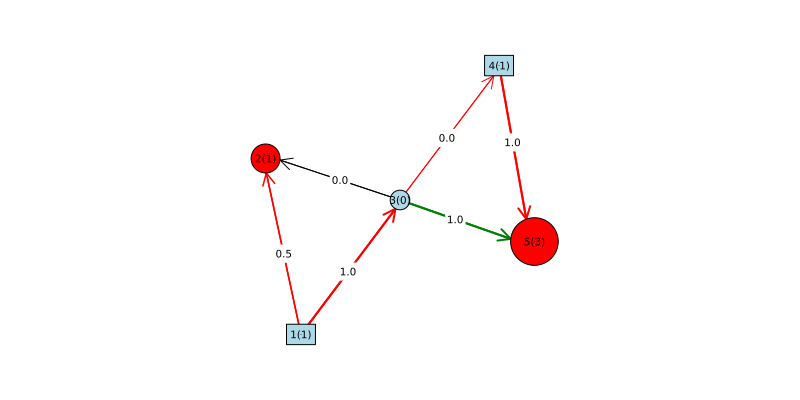

In [21]:
grid_to_graphplot(p_buses, branches, model)

# display(model[:flows] .|>value)

In [22]:
methods(grid_to_graphplot)


# 4 methods for generic function "grid_to_graphplot" from Main:
 [1] grid_to_graphplot(p_buses, branches, model::Model, figsize::Tuple{Int64, Int64}, fontsize::Int64)
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6
 [2] grid_to_graphplot(p_buses, branches, model::Model, figsize::Tuple{Int64, Int64})
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6
 [3] grid_to_graphplot(p_buses, branches, model::Model)
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6
 [4] grid_to_graphplot(p_buses, branches)
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6

In [23]:
typeof(model)

Model (alias for GenericModel{Float64})